# Codificador Automático Variacional (VAE)

**PHABEL ANTONIO LÓPEZ DELGADO**

El **Codificador Automático Variacional** (VAE, por sus siglas en inglés) es un modelo generativo basado en redes neuronales profundas. Su objetivo es aprender una representación comprimida (espacio latente) de los datos de entrada, permitiendo tanto la reconstrucción como la generación de nuevos datos similares.

El VAE difiere de un autoencoder clásico en que, en lugar de codificar los datos a un vector determinista, se aprende una **distribución probabilística** (media y varianza) sobre el espacio latente. Esto permite una mejor generalización y permite muestrear nuevos datos.

Este cuaderno implementa un VAE para imágenes del conjunto de datos MNIST (dígitos escritos a mano), usando capas convolucionales para la codificación y decodificación.

Las principales partes del VAE son:

- El **codificador** que mapea imágenes a un espacio latente distribuido normal multivariado.
- El **muestreo reparametrizado** del vector latente.
- El **decodificador** que reconstruye la imagen desde el vector latente.
- La **función de costo**, que combina el error de reconstrucción (entropía cruzada) y la divergencia Kullback-Leibler (KL) entre la distribución latente aprendida y una distribución normal estándar.



**Objetivo**: Comparar el desempeño de tres arquitecturas de VAE bajo tres condiciones diferentes del hiperparámetro que regula la contribución de la divergencia entre distribuciones en la función de pérdida. β. Los modelos se desarrollan utilizando el conjunto de datos de fashion MNIST.

**Nota**: Este notebook tiene la implementación de un VAE tradicional, un CVAE condicional y de un ConvVAE (convolucional). Todos con el parámetro de divergencia beta=1.0 <https://colab.research.google.com/drive/1cMzM08hsY6buvMYbLE8hsmIE9dKlNMWs#scrollTo=eG8ZfDF-s3_m>. Los notebooks con los tres modelos y otros dos valores de beta=0.85 y beta=0.95 son: <https://colab.research.google.com/drive/1oGbl3S4sFRyQU39oru1xufvCbgv2DzhA#scrollTo=vqYr8ygnEOk-> <https://colab.research.google.com/drive/1-bGVSiiz2PGX4LZP02K-i5YWEE2p2fFC#scrollTo=6oZ0KpZsA4K7>


In [ ]:
# Importar librerias necesarias
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# 1. Modelo del Codificador automático variacional (VAE)

Completa la función `vae` para definir la arquitectura del modelo con base en las siguientes características:

### Arquitectura del modelo:

**Codificador (Encoder)**

1. Capa de entrada: acepta imágenes de forma (28, 28, 1)
2. Tres bloques convolucionales secuenciales:
   - Convolución 2D (64 filtros, kernel 4x4, stride 2x2)
   - Normalización por lotes (BatchNormalization)
   - Activación LeakyReLU (α=0.3)
3. Aplanamiento de características
4. Capas densas para μ y log σ² (n_hidden neuronas cada una)
5. Muestreo estocástico mediante truco de reparametrización

**Decodificador (Decoder)**

1. Capas densas de expansión (32 y 64 neuronas)
2. Reconfiguración a tensor 3D (8, 8, 1)
3. Tres capas de convolución transpuesta:
   - Primera: 64 filtros, kernel 4x4, stride 2x2 (upsampling)
   - Segunda y tercera: 64 filtros, kernel 4x4, stride 1x1
4. Aplanamiento y capa densa final (784 neuronas)
5. Activación sigmoide y reconfiguración a (28, 28, 1)

## Tarea I: Reportar las arquitecturas de los VAE implementados, haciendo énfasis en la diferencia de dimensiones del vector de espacio latente (1 pt)


Aquí se pueden ver tres VAEs, uno con tres bloques convolucionales para imágenes (porque el input son imágenes), uno condicional y otro convolucional con una arquitectura más directa. El primero y el tercero tienen un vector latente bastante semejante y usan el truco de reparametrización. Mientras que el segundo, a ser condicional, posee un vector latente condicionado por las clases de entrada como etiquetas one-hot. El primero y el tercero puede usarse para generación no supervisada, mientras que el segundo para una generación dirigida e inclusive interpolación de clases específicas.

Las tres arquitecturas reciben imágenes de 28X28X1; la segunda también recibe el vector de clases one-hot. Cada arquitectura está descrita en su docstring correspondiente.



In [ ]:
def vae(n_hidden = 8):

    """
    Construye y retorna un modelo de Autocodificador Variacional (VAE) para
    generación y reconstrucción de imágenes utilizando TensorFlow/Keras.

    Esta función implementa una arquitectura completa de VAE que combina un
    codificador convolucional con un decodificador transpuesto convolucional,
    diseñada específicamente para procesar imágenes en escala de grises de
    28x28 píxeles. El modelo emplea el truco de reparametrización para permitir
    el entrenamiento mediante retropropagación en el espacio latente estocástico.

    Parámetros:
    -----------
    n_hidden : int, opcional (default=8)
        Dimensionalidad del espacio latente (espacio de representación comprimida).
        Define el número de variables latentes que codifican la representación
        probabilística de los datos de entrada.

    Retorna:
    --------
    tf.keras.Model
        Modelo de Keras con múltiples salidas:
        - Salida principal: imagen reconstruida de forma (28, 28, 1)
        - Media (μ): vector de medias del espacio latente
        - Log-varianza (log σ²): vector de log-varianzas del espacio latente
    """

    input_layer = tf.keras.Input((28,28,1), name='input_layer')

    # Codificador convolucional
    # Primer bloque convolucional
    xenc = tf.keras.layers.Conv2D(filters=64, kernel_size=4, strides=(2,2),
                                  padding='same', name='conv1')(input_layer)
    xenc = tf.keras.layers.BatchNormalization(name='bn1')(xenc)
    xenc = tf.keras.layers.LeakyReLU(negative_slope=0.3, name='leaky1')(xenc)  # Fixed: alpha -> negative_slope

    # Segundo bloque convolucional
    xenc = tf.keras.layers.Conv2D(filters=64, kernel_size=4, strides=(2,2),
                                  padding='same', name='conv2')(xenc)
    xenc = tf.keras.layers.BatchNormalization(name='bn2')(xenc)
    xenc = tf.keras.layers.LeakyReLU(negative_slope=0.3, name='leaky2')(xenc)  # Fixed: alpha -> negative_slope

    # Tercer bloque convolucional
    xenc = tf.keras.layers.Conv2D(filters=64, kernel_size=4, strides=(2,2),
                                  padding='same', name='conv3')(xenc)
    xenc = tf.keras.layers.BatchNormalization(name='bn3')(xenc)
    xenc = tf.keras.layers.LeakyReLU(negative_slope=0.3, name='leaky3')(xenc)  # Fixed: alpha -> negative_slope

    # Capas de codificación a espacio latente
    # Aplanamiento de características
    xenc_flat = tf.keras.layers.Flatten(name='flatten_encoder')(xenc)

    # Capas densas para μ y log σ²
    mean_layer = tf.keras.layers.Dense(n_hidden, name='mean_layer')(xenc_flat)
    log_var_layer = tf.keras.layers.Dense(n_hidden, name='log_var_layer')(xenc_flat)

    # Truco de reparametrización usando solo Keras operations
    def sampling(args):
        """Reparameterization trick by sampling from an isotropic unit Gaussian."""
        z_mean, z_log_var = args
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    z = tf.keras.layers.Lambda(sampling, output_shape=(n_hidden,), name='z_vector')([mean_layer, log_var_layer])

    # Decodificador
    # Capas densas de expansión
    xdec = tf.keras.layers.Dense(32, activation='relu', name='dense_expand1')(z)
    xdec = tf.keras.layers.Dense(64, activation='relu', name='dense_expand2')(xdec)

    # Reconfiguración a tensor 3D (8, 8, 1)
    xdec = tf.keras.layers.Dense(8*8*1, activation='relu', name='dense_reshape')(xdec)
    xdec = tf.keras.layers.Reshape((8, 8, 1), name='reshape_3d')(xdec)

    # Primera convolución transpuesta (upsampling)
    xdec = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=4, strides=(2,2),
                                          padding='same', activation='relu',
                                          name='conv_transpose1')(xdec)

    # Segunda convolución transpuesta
    xdec = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=4, strides=(1,1),
                                          padding='same', activation='relu',
                                          name='conv_transpose2')(xdec)

    # Tercera convolución transpuesta
    xdec = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=4, strides=(1,1),
                                          padding='same', activation='relu',
                                          name='conv_transpose3')(xdec)

    # Aplanamiento y capa densa final (784 neuronas)
    xdec_flat = tf.keras.layers.Flatten(name='flatten_decoder')(xdec)
    xdec_dense = tf.keras.layers.Dense(784, name='dense_final')(xdec_flat)

    # Activación sigmoide y reconfiguración a (28, 28, 1)
    xdec_sigmoid = tf.keras.layers.Activation('sigmoid', name='sigmoid_activation')(xdec_dense)
    xout = tf.keras.layers.Reshape((28, 28, 1), name='output_reshape')(xdec_sigmoid)

    vae_model = tf.keras.Model(inputs = input_layer, outputs = [xout, mean_layer, log_var_layer], name='vae')

    return vae_model

In [ ]:
def vae_cond(n_hidden = 8):

    """
    Construye y retorna un modelo de Autocodificador Variacional (VAE) para
    generación y reconstrucción de imágenes utilizando TensorFlow/Keras.

    Esta función implementa una arquitectura completa de VAE que combina un
    codificador convolucional con un decodificador transpuesto convolucional,
    diseñada específicamente para procesar imágenes en escala de grises de
    28x28 píxeles. El modelo emplea el truco de reparametrización para permitir
    el entrenamiento mediante retropropagación en el espacio latente estocástico.

    Parámetros:
    -----------
    n_hidden : int, opcional (default=8)
        Dimensionalidad del espacio latente (espacio de representación comprimida).
        Define el número de variables latentes que codifican la representación
        probabilística de los datos de entrada.

    Retorna:
    --------
    tf.keras.Model
        Modelo de Keras con múltiples salidas:
        - Salida principal: imagen reconstruida de forma (28, 28, 1)
        - Media (μ): vector de medias del espacio latente
        - Log-varianza (log σ²): vector de log-varianzas del espacio latente
    """

    input_layer = tf.keras.Input((28,28,1), name='input_layer')
    input_labels = tf.keras.Input((10,), name = 'input_labels')
    #input_labels = tf.keras.Input((1,), name='input_labels')

    # Codificador convolucional
    xlabels = tf.keras.layers.Dense(28*28*10)(input_labels)
    #xlabels = tf.keras.layers.Embedding(10, 28*28*10)(input_labels)
    xlabels = tf.keras.layers.Reshape((28,28,10))(xlabels)

    xenc = tf.keras.layers.Concatenate()([input_layer, xlabels])
    for n in range(3):

        xenc = tf.keras.layers.Conv2D(filters = 64, kernel_size = 4, strides=(2,2))(xenc)
        xenc = tf.keras.layers.BatchNormalization()(xenc)
        xenc = tf.keras.layers.LeakyReLU(0.3)(xenc)

    # Capas de codificación a espacio latente
    xenc = tf.keras.layers.Flatten()(xenc)
    mean_layer = tf.keras.layers.Dense(n_hidden)(xenc)
    log_var_layer = tf.keras.layers.Dense(n_hidden)(xenc)

    # Truco de reparametrización
    epsilon = tf.keras.layers.Lambda(lambda args: tf.random.normal(tf.shape(args)),
                                     output_shape=lambda s: s,
                                     name='epsilon_layer')(mean_layer)
    # Hacer la reparametrización con lambda
    z = tf.keras.layers.Lambda(
        lambda args: args[0] + tf.multiply(args[1], tf.exp(0.5 * args[2])),
        name='z_vector')([mean_layer, epsilon, log_var_layer])

    # Decodificador
    xdec = tf.keras.layers.Dense(32)(z)
    xdec = tf.keras.layers.LeakyReLU(0.3)(xdec)

    xdec = tf.keras.layers.Dense(64)(xdec)
    xdec = tf.keras.layers.LeakyReLU(0.3)(xdec)
    xdec = tf.keras.layers.Reshape((8,8,1))(xdec)

    # Capas convolucionales transpuestas
    xdec = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=4,
                                           strides=(2,2), padding='same', activation='relu')(xdec)
    xdec =  tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=4,
                                            strides=(1,1), padding='same', activation='relu')(xdec)
    xdec = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=4,
                                           strides=(1,1), padding='same', activation='relu')(xdec)

    # Aplanamiento y capa densa final
    xdec = tf.keras.layers.Flatten()(xdec)
    xdec = tf.keras.layers.Dense(28*28)(xdec)
    xdec = tf.keras.layers.Activation('sigmoid')(xdec)
    xout = tf.keras.layers.Reshape((28,28,1), name='output_layer')(xdec)

    # Recopilación del modelo
    vae_model = tf.keras.Model(inputs = [input_layer, input_labels],
                               outputs = [xout, mean_layer, log_var_layer], name='vae')

    return vae_model

In [ ]:
def vae_conv(n_hidden = 8):

    """
    Construye y retorna un modelo de Autocodificador Variacional (VAE) para
    generación y reconstrucción de imágenes utilizando TensorFlow/Keras.

    Esta función implementa una arquitectura completa de VAE que combina un
    codificador convolucional con un decodificador transpuesto convolucional,
    diseñada específicamente para procesar imágenes en escala de grises de
    28x28 píxeles. El modelo emplea el truco de reparametrización para permitir
    el entrenamiento mediante retropropagación en el espacio latente estocástico.

    Parámetros:
    -----------
    n_hidden : int, opcional (default=8)
        Dimensionalidad del espacio latente (espacio de representación comprimida).
        Define el número de variables latentes que codifican la representación
        probabilística de los datos de entrada.

    Retorna:
    --------
    tf.keras.Model
        Modelo de Keras con múltiples salidas:
        - Salida principal: imagen reconstruida de forma (28, 28, 1)
        - Media (μ): vector de medias del espacio latente
        - Log-varianza (log σ²): vector de log-varianzas del espacio latente
    """

    input_layer = tf.keras.Input((28,28,1), name='input_layer')

    # Codificador convolucional

    for n in range(3):

        if n == 0:
            xenc = tf.keras.layers.Conv2D(filters = 64, kernel_size = 4, strides=(2,2))(input_layer)
        else:
            xenc = tf.keras.layers.Conv2D(filters = 64, kernel_size = 4, strides=(2,2))(xenc)
        xenc = tf.keras.layers.BatchNormalization()(xenc)
        xenc = tf.keras.layers.LeakyReLU(0.3)(xenc)

    # Capas de codificación a espacio latente
    xenc = tf.keras.layers.Flatten()(xenc)
    mean_layer = tf.keras.layers.Dense(n_hidden)(xenc)
    log_var_layer = tf.keras.layers.Dense(n_hidden)(xenc)

    # Truco de reparametrización
    #epsilon = tf.keras.layers.Lambda(lambda x: tf.random.normal(tf.stack([tf.shape(x)[0], n_hidden])),
    #                                 name='epsilon_layer')(xenc)
    #z = tf.keras.layers.Add(name='z_vector')([mean_layer, tf.multiply(epsilon, tf.exp(0.5*log_var_layer))])
    # Generar epsilon en una Lambda
    epsilon = tf.keras.layers.Lambda(lambda args: tf.random.normal(tf.shape(args)),
                                     output_shape=lambda s: s,
                                     name='epsilon_layer')(mean_layer)
    # Luego, en otra Lambda, hacer la reparametrización
    z = tf.keras.layers.Lambda(
        lambda args: args[0] + tf.multiply(args[1], tf.exp(0.5 * args[2])),
        name='z_vector')([mean_layer, epsilon, log_var_layer])


    # Decodificador
    xdec = tf.keras.layers.Dense(32)(z)
    xdec = tf.keras.layers.LeakyReLU(0.3)(xdec)

    xdec = tf.keras.layers.Dense(64)(xdec)
    xdec = tf.keras.layers.LeakyReLU(0.3)(xdec)
    xdec = tf.keras.layers.Reshape((8,8,1))(xdec)

    xdec = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=4,
                                           strides=(2,2), padding='same', activation='relu')(xdec)
    xdec =  tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=4,
                                            strides=(1,1), padding='same', activation='relu')(xdec)
    xdec = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=4,
                                           strides=(1,1), padding='same', activation='relu')(xdec)

    xdec = tf.keras.layers.Flatten()(xdec)
    xdec = tf.keras.layers.Dense(28*28)(xdec)
    xdec = tf.keras.layers.Activation('sigmoid')(xdec)
    xout = tf.keras.layers.Reshape((28,28,1), name='output_layer')(xdec)

    vae_model = tf.keras.Model(inputs = input_layer, outputs = [xout, mean_layer, log_var_layer], name='vae')

    return vae_model

# 2. Funciones auxiliares

In [ ]:
def data_load():

    """
    Carga y preprocesa el conjunto de datos MNIST para entrenamiento de modelos
    de aprendizaje profundo.

    Esta función utilitaria descarga automáticamente el dataset MNIST desde los
    repositorios de Keras, realiza el preprocesamiento estándar incluyendo
    normalización de píxeles y expansión dimensional para compatibilidad con
    arquitecturas convolucionales que requieren canales explícitos.

    Retorna:
    --------
    tuple
        Tupla de cuatro elementos conteniendo los conjuntos de datos procesados:

        train_x : np.ndarray
            Imágenes de entrenamiento normalizadas.
            Forma: (60000, 28, 28, 1), dtype: float32, rango: [0, 1]

        train_y : np.ndarray
            Etiquetas de entrenamiento (dígitos 0-9).
            Forma: (60000,), dtype: uint8

        test_x : np.ndarray
            Imágenes de prueba normalizadas.
            Forma: (10000, 28, 28, 1), dtype: float32, rango: [0, 1]

        test_y : np.ndarray
            Etiquetas de prueba (dígitos 0-9).
            Forma: (10000,), dtype: uint8

    Transformaciones aplicadas:
    ---------------------------
    1. **Expansión dimensional**: Añade dimensión de canal usando np.newaxis
       - Transforma de (N, 28, 28) a (N, 28, 28, 1)
       - Necesario para compatibilidad con capas Conv2D de TensorFlow

    2. **Normalización de píxeles**: División por 255.0
       - Convierte valores enteros [0, 255] a flotantes [0.0, 1.0]
       - Mejora la estabilidad numérica durante el entrenamiento
       - Facilita la convergencia de algoritmos de optimización

    """
    #(train_x, train_y), (test_x, test_y) = tf.keras.datasets.mnist.load_data()
    # Dataset para FashionMNIST
    (train_x, train_y), (test_x, test_y) = tf.keras.datasets.fashion_mnist.load_data()
    train_x, test_x = train_x[..., np.newaxis], test_x[..., np.newaxis]
    train_x, test_x = train_x/255.0, test_x/255.0
    return train_x, train_y, test_x, test_y


def create_set(tensors=list):
    """
    Construye un conjunto de datos de TensorFlow combinando múltiples tensores
    mediante operación de cremallera (zip).

    Esta función utilitaria facilita la creación de pipelines de datos eficientes
    para el entrenamiento de modelos de aprendizaje automático, permitiendo la
    combinación sincronizada de múltiples fuentes de datos (características,
    etiquetas, metadatos) en un único objeto tf.data.Dataset optimizado.

    Parámetros:
    -----------
    tensors : list
        Lista de tensores o arrays de NumPy que serán combinados elemento por
        elemento. Todos los tensores deben tener la misma dimensión en el eje 0
        (mismo número de muestras).

        Ejemplo: [features, labels, weights] donde cada elemento tiene forma
        (N, ...) con N muestras.

    Retorna:
    --------
    tf.data.Dataset
        Dataset de TensorFlow que produce tuplas conteniendo elementos
        correspondientes de cada tensor de entrada. Cada iteración del dataset
        retorna una tupla (tensor1[i], tensor2[i], ..., tensorN[i]).
    """
    dtensors = list()
    for i in tensors:
        dtensors += [tf.data.Dataset.from_tensor_slices(i)]
    dtensors = tuple(dtensors)

    return tf.data.Dataset.zip(dtensors)



## Tarea II: Reportar los valores de los hiperparámetros β utilizados, siendo uno de ellos igual a la unidad (1 pt)

En este notebook se utilizé beta=1.0 para los tres modelos. Aquí se muestran los resultados para beta=0.85 <https://colab.research.google.com/drive/1oGbl3S4sFRyQU39oru1xufvCbgv2DzhA#scrollTo=vqYr8ygnEOk->, y beta=0.95 <https://colab.research.google.com/drive/1-bGVSiiz2PGX4LZP02K-i5YWEE2p2fFC#scrollTo=6oZ0KpZsA4K7>

Cabe destacar que este parámetro beta es muy importante porque definie la importancia entre los ambos elementos con respecto a la pérdida/divergencia de KL. Se utilizó un beta=1.0 estable, con un balance equilibrado entre reconstrucción y regularización. Y se usaron dos betas<1.0, particularmente 0.85 y 0.95 que priorizaron la reconstrucción sobre regularización, dando un espacion latente menos organizado, pero forzando una mejor calidad de reconstrucción. Se intentó probar con valores de beta>1.0, pero el recurso computacional de Google Collab no soportaba el trabajo, posiblemente porque el espacio latente se encontraba más factorizado.

In [ ]:
def vae_loss(x_real, model_output, beta=1):
    """
    Calcula la función de pérdida completa para Autocodificadores Variacionales (VAE)
    combinando el término de reconstrucción y el término de regularización KL.

    La formulación incluye un hiperparámetro β que permite controlar el balance
    entre la calidad de reconstrucción y la regularización del espacio latente,
    técnica conocida como β-VAE en la literatura especializada.

    Parámetros:
    -----------
    x_real : tf.Tensor
        Tensor conteniendo las imágenes originales de entrada.
        Forma esperada: (batch_size, height, width, channels)
        Rango de valores: [0, 1] (imágenes normalizadas)

    model_output : tuple
        Tupla de tres elementos retornada por el modelo VAE:
        - xrec: imágenes reconstruidas (misma forma que x_real)
        - mean: medias del espacio latente (batch_size, latent_dim)
        - log_var: log-varianzas del espacio latente (batch_size, latent_dim)

    beta : float, opcional (default=1)
        Hiperparámetro de ponderación para el término KL. Controla el balance
        entre reconstrucción y regularización:
        - β = 1: VAE estándar (formulación original)
        - β > 1: Mayor regularización, representaciones más desacopladas
        - β < 1: Menor regularización, mejor reconstrucción

    Retorna:
    --------
    tf.Tensor
        Valor escalar de la pérdida total combinada, lista para optimización
        mediante descenso de gradiente.

    """
    xrec, mean, log_var = model_output

    loss_fn = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE) #(batch, 28, 28)

    loss_rec = tf.reduce_mean(tf.reduce_sum(loss_fn(x_real, xrec), axis=(1, 2)))
    loss_kl = KL_div(mean, log_var)

    return loss_rec + beta*loss_kl


## Función de Costo del VAE

La función de pérdida del VAE consta de dos componentes fundamentales:

1. **Pérdida de reconstrucción**: mide qué tan bien el decodificador reconstruye los datos originales. En este caso, se utiliza la **entropía cruzada binaria**, adecuada para imágenes en escala de grises con valores normalizados entre 0 y 1.

2. **Divergencia KL**: mide qué tan cerca está la distribución latente aprendida (una normal con media y varianza aprendidas) de una distribución normal estándar, $\mathcal{N}(0, I)$. Esta parte actúa como regularizador y se calcula de la siguiente forma:

$$D_{KL}(q(z|x) || p(z)) = -\frac{1}{2} \sum (1 + \log(\sigma^2) - \mu^2 - \sigma^2)$$

Donde $\mu$ y $\sigma^2$ son la media y varianza aprendidas por el codificador.

La pérdida total es la suma ponderada de ambos términos, lo que permite al modelo balancear fidelidad en la reconstrucción y capacidad generativa.


In [ ]:
def KL_div(mean, log_var):

    """
    Calcula la divergencia de Kullback-Leibler entre una distribución gaussiana
    multivariada y una distribución normal estándar.

    Esta función implementa el cálculo analítico de la divergencia KL entre
    q(z|x) = N(μ, σ²I) y p(z) = N(0, I), componente fundamental en la función
    objetivo de los Autocodificadores Variacionales (VAE). La formulación
    corresponde al término de regularización que fuerza al espacio latente
    aprendido a aproximarse a una distribución a priori conocida.

    Parámetros:
    -----------
    mean : tf.Tensor
        Tensor que contiene los valores de la media (μ) de la distribución
        posterior aproximada q(z|x) para cada muestra del lote.
        Forma esperada: (batch_size, latent_dim)

    log_var : tf.Tensor
        Tensor que contiene los valores del logaritmo de la varianza (log σ²)
        de la distribución posterior aproximada q(z|x) para cada muestra del lote.
        Forma esperada: (batch_size, latent_dim)

    Retorna:
    --------
    tf.Tensor
        Valor escalar de la divergencia KL promediada sobre el lote de entrenamiento.
        Representa la pérdida de regularización en el espacio latente.
    """

    latent_loss = -0.5 * tf.reduce_mean(1 + log_var - tf.square(mean) - tf.exp(log_var))
    return latent_loss

Proceso de entrenamiento:  
-------------------------  

1. **Preparación de datos**:  
   - Mezcla aleatoria de conjuntos con semilla fija (reproducibilidad)  
   - Agrupación en lotes con eliminación de lotes incompletos  
   - Configuración de re-mezcla en cada época  

2. **Configuración de optimización**:  
   - Inicialización del optimizador Adam con tasa de aprendizaje especificada  
   - Preparación de estructuras para almacenamiento de métricas  

3. **Bucle de entrenamiento por época**:  
   - **Fase de entrenamiento**:   
     * Forward pass a través del modelo  
     * Cálculo de pérdida VAE (reconstrucción + β×KL)  
     * Backward pass con cálculo automático de gradientes  
     * Actualización de parámetros mediante Adam  
   - **Fase de evaluación**:  
     * Evaluación en conjunto de prueba sin actualización de parámetros  
     * Cálculo de métricas de rendimiento  

4. **Registro y monitoreo**:  
   - Almacenamiento de pérdidas promedio por época  
   - Visualización de progreso en tiempo real  
   - Generación de DataFrame con historial completo  

Consideraciones técnicas:  
-------------------------  

**Gestión de memoria**:  
- Utiliza tf.TensorArray para almacenamiento eficiente de pérdidas por lote  
- Emplea tf.GradientTape para diferenciación automática controlada  
- Libera automáticamente recursos de gradientes después de cada actualización  

**Reproducibilidad**:  
- Semilla fija (3451) para mezcla de datos garantiza resultados reproducibles  
- Re-mezcla en cada época previene sobreajuste a orden específico de datos  

**Optimización**:  
- drop_remainder=True asegura lotes de tamaño consistente  
- Adam proporciona adaptación automática de tasas de aprendizaje por parámetro  


In [ ]:
def fit_vae(model, training_set, test_set, batch_size = 1, lr = 1e-3, num_epochs=10, beta=1):
    """
    Entrena un modelo de Autocodificador Variacional (VAE) utilizando un bucle
    de entrenamiento personalizado con seguimiento de métricas de pérdida.

    Parámetros:
    -----------
    model : tf.keras.Model
        Modelo VAE previamente construido que debe retornar una tupla de tres
        elementos: (imagen_reconstruida, media_latente, log_varianza_latente).
        El modelo debe ser compatible con la función vae_loss().

    training_set : tf.data.Dataset
        Conjunto de datos de entrenamiento conteniendo tuplas (imágenes, etiquetas).
        Las etiquetas son ignoradas durante el entrenamiento no supervisado del VAE.

    test_set : tf.data.Dataset
        Conjunto de datos de prueba para evaluación del modelo durante el
        entrenamiento. Debe tener la misma estructura que training_set.

    batch_size : int, opcional (default=1)
        Tamaño del lote para el entrenamiento.

    lr : float, opcional (default=1e-3)
        Tasa de aprendizaje para el optimizador Adam.

    num_epochs : int, opcional (default=10)
        Número de épocas de entrenamiento.

    beta : float, opcional (default=1)
        Hiperparámetro de ponderación para el término de regularización KL
        en la función de pérdida del VAE (β-VAE). Controla el balance entre
        reconstrucción y regularización del espacio latente.

    Retorna:
    --------
    tuple
        Tupla de dos elementos:

        model : tf.keras.Model
            Modelo VAE entrenado con parámetros actualizados.

        df_losses : pd.DataFrame
            DataFrame de pandas conteniendo el historial de pérdidas con columnas:
            - 'training_loss': pérdida promedio en conjunto de entrenamiento por época
            - 'test_loss': pérdida promedio en conjunto de prueba por época
    """
    training_set = training_set.shuffle(200000, seed = 3451, reshuffle_each_iteration=True)
    training_set = training_set.batch(batch_size, drop_remainder=True)

    test_set = test_set.shuffle(200000, seed = 3451, reshuffle_each_iteration=True)
    test_set = test_set.batch(batch_size, drop_remainder=True)

    optimizer = tf.keras.optimizers.Adam(lr)


    losses_test = list()
    losses_train = list()
    for epoch in range(num_epochs):

        loss_train = tf.TensorArray(tf.float32, size = len(training_set))
        for i, (x_train, _) in enumerate(training_set):

            with tf.GradientTape() as tape:
                model_output = model(x_train)
                loss = vae_loss(x_train, model_output, beta=beta)

            loss_train = loss_train.write(i, loss)
            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        loss_train = loss_train.stack()
        loss_train = tf.reduce_mean(loss_train).numpy()

        loss_test = tf.TensorArray(tf.float32, size=len(test_set))
        for i, (x_test,_) in enumerate(test_set):
            model_output = model(x_test)
            loss = vae_loss(x_test, model_output, beta=beta)

            loss_test = loss_test.write(i, loss)

        loss_test = loss_test.stack()
        loss_test = tf.reduce_mean(loss_test).numpy()

        losses_train.append(loss_train)
        losses_test.append(loss_test)
        print(f"Epoch {epoch+1} | Training Loss: {loss_train} | Test Loss: {loss_test}")

    df_losses = pd.DataFrame({'training_loss': losses_train, 'test_loss':losses_test})
    return model, df_losses

In [ ]:
def fit_vae_cond(model, training_set, test_set, batch_size = 1, lr = 1e-3, num_epochs=10, beta=1):
    """
    Entrena un modelo de Autocodificador Variacional Condicional (CVAE) utilizando un bucle
    de entrenamiento personalizado con seguimiento de métricas de pérdida.

    Parámetros:
    -----------
    model : tf.keras.Model
        Modelo VAE previamente construido que debe retornar una tupla de tres
        elementos: (imagen_reconstruida, media_latente, log_varianza_latente).
        El modelo debe ser compatible con la función vae_loss().

    training_set : tf.data.Dataset
        Conjunto de datos de entrenamiento conteniendo tuplas (imágenes, etiquetas).
        Las etiquetas son ignoradas durante el entrenamiento no supervisado del VAE.

    test_set : tf.data.Dataset
        Conjunto de datos de prueba para evaluación del modelo durante el
        entrenamiento. Debe tener la misma estructura que training_set.

    batch_size : int, opcional (default=1)
        Tamaño del lote para el entrenamiento.

    lr : float, opcional (default=1e-3)
        Tasa de aprendizaje para el optimizador Adam.

    num_epochs : int, opcional (default=10)
        Número de épocas de entrenamiento.

    beta : float, opcional (default=1)
        Hiperparámetro de ponderación para el término de regularización KL
        en la función de pérdida del VAE (β-VAE). Controla el balance entre
        reconstrucción y regularización del espacio latente.

    Retorna:
    --------
    tuple
        Tupla de dos elementos:

        model : tf.keras.Model
            Modelo VAE entrenado con parámetros actualizados.

        df_losses : pd.DataFrame
            DataFrame de pandas conteniendo el historial de pérdidas con columnas:
            - 'training_loss': pérdida promedio en conjunto de entrenamiento por época
            - 'test_loss': pérdida promedio en conjunto de prueba por época
    """
    training_set = training_set.shuffle(200000, seed = 3451, reshuffle_each_iteration=True)
    training_set = training_set.batch(batch_size, drop_remainder=True)

    test_set = test_set.shuffle(200000, seed = 3451, reshuffle_each_iteration=True)
    test_set = test_set.batch(batch_size, drop_remainder=True)

    optimizer = tf.keras.optimizers.Adam(lr)


    losses_test = list()
    losses_train = list()
    for epoch in range(num_epochs):

        loss_train = tf.TensorArray(tf.float32, size = len(training_set))
        for i, (x_train, y_train) in enumerate(training_set):

            train_labels = tf.one_hot(y_train, depth=10)
            with tf.GradientTape() as tape:
                model_output = model([x_train, train_labels])
                loss = vae_loss(x_train, model_output, beta=beta)

            loss_train = loss_train.write(i, loss)
            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        loss_train = loss_train.stack()
        loss_train = tf.reduce_mean(loss_train).numpy()


        loss_test = tf.TensorArray(tf.float32, size=len(test_set))
        for i, (x_test, y_test) in enumerate(test_set):
            test_labels = tf.one_hot(y_test, depth=10)
            #y_test = tf.cast(y_test, tf.float32)
            #x_test = tf.cast(x_test, tf.float32)
            model_output = model([x_test, test_labels], training=False)
            loss = vae_loss(x_test, model_output, beta=beta)

            loss_test = loss_test.write(i, loss)

        loss_test = loss_test.stack()
        loss_test = tf.reduce_mean(loss_test).numpy()

        losses_train.append(loss_train)
        losses_test.append(loss_test)
        print(f"Epoch {epoch+1} | Training Loss: {loss_train} | Test Loss: {loss_test}")

    df_losses = pd.DataFrame({'training_loss': losses_train, 'test_loss':losses_test})
    return model, df_losses

# 3. Entrenamiento del modelo

## Parte III: Reportar las curvas de aprendizaje de los conjuntos de entrenamiento y de prueba (2 pts).

In [ ]:
n_hidden = 2

#### 3.1 VAE

In [ ]:
model_1 = vae(n_hidden=n_hidden)

In [ ]:
model_1.summary()

Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv2D)      │ (None, 14, 14,    │      1,088 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn1                 │ (None, 14, 14,    │        256 │ conv1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky1 (LeakyReLU)  │ (None, 14, 14,    │          0 │ bn1[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2 (Conv2D)      │ (None, 7, 7, 64)  │     65,600 │ leaky1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn2                 │ (None, 7, 7, 64)  │        256 │ conv2[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky2 (LeakyReLU)  │ (None, 7, 7, 64)  │          0 │ bn2[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3 (Conv2D)      │ (None, 4, 4, 64)  │     65,600 │ leaky2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn3                 │ (None, 4, 4, 64)  │        256 │ conv3[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky3 (LeakyReLU)  │ (None, 4, 4, 64)  │          0 │ bn3[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_encoder     │ (None, 1024)      │          0 │ leaky3[0][0]      │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean_layer (Dense)  │ (None, 2)         │      2,050 │ flatten_encoder[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ log_var_layer       │ (None, 2)         │      2,050 │ flatten_encoder[… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_vector (Lambda)   │ (None, 2)         │          0 │ mean_layer[0][0], │
│                     │                   │            │ log_var_layer[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_expand1       │ (None, 32)        │         96 │ z_vector[0][0]    │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_expand2       │ (None, 64)        │      2,112 │ dense_expand1[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_reshape       │ (None, 64)        │      4,160 │ dense_expand2[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3d          │ (None, 8, 8, 1)   │          0 │ dense_reshape[0]… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 13,121,652 (50.06 MB)

 Trainable params: 13,121,268 (50.05 MB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
train_x, train_y, test_x, test_y = data_load()

training_set = create_set([train_x, train_y])
test_set = create_set([test_x, test_y])

In [ ]:
batch_size = 256
lr = 1e-3
num_epochs = 10

model, df_losses = fit_vae(model_1, training_set, test_set, batch_size = batch_size, lr = lr, num_epochs=num_epochs)

Epoch 1 | Training Loss: 45.667823791503906 | Test Loss: 30.867218017578125
Epoch 2 | Training Loss: 29.166610717773438 | Test Loss: 27.83608055114746
Epoch 3 | Training Loss: 27.453767776489258 | Test Loss: 26.998672485351562
Epoch 4 | Training Loss: 26.747398376464844 | Test Loss: 26.47422218322754
Epoch 5 | Training Loss: 26.238224029541016 | Test Loss: 26.168373107910156
Epoch 6 | Training Loss: 25.940797805786133 | Test Loss: 25.745174407958984
Epoch 7 | Training Loss: 25.68958282470703 | Test Loss: 25.5673770904541
Epoch 8 | Training Loss: 25.441320419311523 | Test Loss: 25.55392074584961
Epoch 9 | Training Loss: 25.324478149414062 | Test Loss: 25.580055236816406
Epoch 10 | Training Loss: 25.069644927978516 | Test Loss: 25.193904876708984


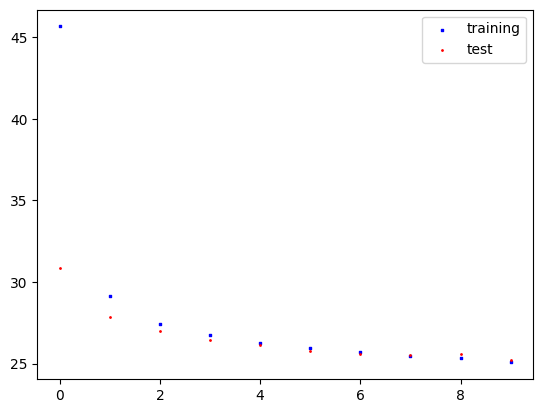

In [ ]:
plt.figure()
plt.scatter(np.arange(df_losses.shape[0]), df_losses['training_loss'].values,
            color='blue', marker='s', s=1, label='training')
plt.scatter(np.arange(df_losses.shape[0]), df_losses['test_loss'].values,
            color='red', marker='o', s=1, label='test')
plt.legend(loc='best')
plt.show()

#### 3.2. CVAE

In [ ]:
model_2 = vae_cond(n_hidden=n_hidden)

In [ ]:
model_2.summary()

Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_labels        │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_29 (Dense)    │ (None, 7840)      │     86,240 │ input_labels[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer         │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_13          │ (None, 28, 28,    │          0 │ dense_29[0][0]    │
│ (Reshape)           │ 10)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 28, 28,    │          0 │ input_layer[0][0… │
│ (Concatenate)       │ 11)               │            │ reshape_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 13, 13,    │     11,328 │ concatenate_3[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 13, 13,    │        256 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_23      │ (None, 13, 13,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 5, 5, 64)  │     65,600 │ leaky_re_lu_23[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 5, 5, 64)  │        256 │ conv2d_10[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_24      │ (None, 5, 5, 64)  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 1, 1, 64)  │     65,600 │ leaky_re_lu_24[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1, 1, 64)  │        256 │ conv2d_11[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_25      │ (None, 1, 1, 64)  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_10          │ (None, 64)        │          0 │ leaky_re_lu_25[0… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_30 (Dense)    │ (None, 2)         │        130 │ flatten_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ epsilon_layer       │ (None, 2)         │          0 │ dense_30[0][0]    │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_31 (Dense)    │ (None, 2)         │        130 │ flatten_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 13,210,132 (50.39 MB)

 Trainable params: 13,209,748 (50.39 MB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
train_x, train_y, test_x, test_y = data_load()

training_set = create_set([train_x, train_y])
test_set = create_set([test_x, test_y])

In [ ]:
batch_size = 256
lr = 1e-3
num_epochs = 10

model, df_losses = fit_vae_cond(model_2, training_set, test_set, batch_size = batch_size, lr = lr, num_epochs=num_epochs)

Epoch 1 | Training Loss: 41.76018524169922 | Test Loss: 29.410385131835938
Epoch 2 | Training Loss: 28.09172821044922 | Test Loss: 27.233686447143555
Epoch 3 | Training Loss: 26.648399353027344 | Test Loss: 26.185625076293945
Epoch 4 | Training Loss: 26.04690933227539 | Test Loss: 25.91128921508789
Epoch 5 | Training Loss: 25.700176239013672 | Test Loss: 25.48820686340332
Epoch 6 | Training Loss: 25.385391235351562 | Test Loss: 25.522899627685547
Epoch 7 | Training Loss: 25.167083740234375 | Test Loss: 25.248260498046875
Epoch 8 | Training Loss: 25.020862579345703 | Test Loss: 25.065515518188477
Epoch 9 | Training Loss: 24.801218032836914 | Test Loss: 24.937015533447266
Epoch 10 | Training Loss: 24.68866729736328 | Test Loss: 25.17475128173828


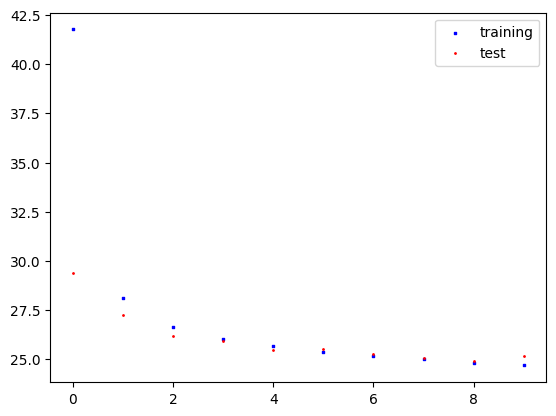

In [ ]:
plt.figure()
plt.scatter(np.arange(df_losses.shape[0]), df_losses['training_loss'].values,
            color='blue', marker='s', s=1, label='training')
plt.scatter(np.arange(df_losses.shape[0]), df_losses['test_loss'].values,
            color='red', marker='o', s=1, label='test')
plt.legend(loc='best')
plt.show()

#### 3.3. ConvVAE

In [ ]:
model_3 = vae_conv(n_hidden=n_hidden)

In [ ]:
model_3.summary()

Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 13, 13,    │      1,088 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 13, 13,    │        256 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_28      │ (None, 13, 13,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 5, 5, 64)  │     65,600 │ leaky_re_lu_28[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 5, 5, 64)  │        256 │ conv2d_13[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_29      │ (None, 5, 5, 64)  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 1, 1, 64)  │     65,600 │ leaky_re_lu_29[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1, 1, 64)  │        256 │ conv2d_14[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_30      │ (None, 1, 1, 64)  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_12          │ (None, 64)        │          0 │ leaky_re_lu_30[0… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_35 (Dense)    │ (None, 2)         │        130 │ flatten_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ epsilon_layer       │ (None, 2)         │          0 │ dense_35[0][0]    │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_36 (Dense)    │ (None, 2)         │        130 │ flatten_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_vector (Lambda)   │ (None, 2)         │          0 │ dense_35[0][0],   │
│                     │                   │            │ epsilon_layer[0]… │
│                     │                   │            │ dense_36[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_37 (Dense)    │ (None, 32)        │         96 │ z_vector[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_31      │ (None, 32)        │          0 │ dense_37[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_38 (Dense)    │ (None, 64)        │      2,112 │ leaky_re_lu_31[0… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 13,113,652 (50.02 MB)

 Trainable params: 13,113,268 (50.02 MB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
train_x, train_y, test_x, test_y = data_load()

training_set = create_set([train_x, train_y])
test_set = create_set([test_x, test_y])

In [ ]:
batch_size = 256
lr = 1e-3
num_epochs = 10

model, df_losses = fit_vae(model_3, training_set, test_set, batch_size = batch_size, lr = lr, num_epochs=num_epochs)

Epoch 1 | Training Loss: 42.62302017211914 | Test Loss: 29.83348274230957
Epoch 2 | Training Loss: 28.770925521850586 | Test Loss: 28.1922550201416
Epoch 3 | Training Loss: 27.54651641845703 | Test Loss: 26.9886417388916
Epoch 4 | Training Loss: 26.82068634033203 | Test Loss: 27.526424407958984
Epoch 5 | Training Loss: 26.582656860351562 | Test Loss: 26.45415496826172
Epoch 6 | Training Loss: 26.171894073486328 | Test Loss: 25.986331939697266
Epoch 7 | Training Loss: 25.930116653442383 | Test Loss: 26.09651756286621
Epoch 8 | Training Loss: 25.78150749206543 | Test Loss: 25.61888313293457
Epoch 9 | Training Loss: 25.62468910217285 | Test Loss: 25.7322940826416
Epoch 10 | Training Loss: 25.484882354736328 | Test Loss: 25.627851486206055


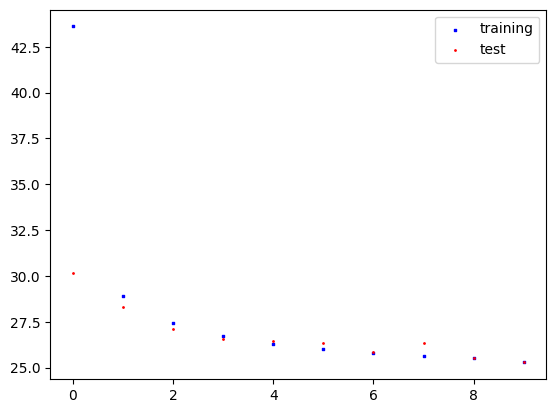

In [ ]:
plt.figure()
plt.scatter(np.arange(df_losses.shape[0]), df_losses['training_loss'].values,
            color='blue', marker='s', s=1, label='training')
plt.scatter(np.arange(df_losses.shape[0]), df_losses['test_loss'].values,
            color='red', marker='o', s=1, label='test')
plt.legend(loc='best')
plt.show()

# 4. Evaluación del modelo

## Tarea IV: Presentar algunas imágenes generadas con los diferentes modelos (3 pts). Tarea V: Presentar la proyección obtenida bajo t-SNE del espacio latente (3 pts).



#### 4.1. VAE

In [ ]:
xrec, _, _ = model_1.predict(test_x)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step


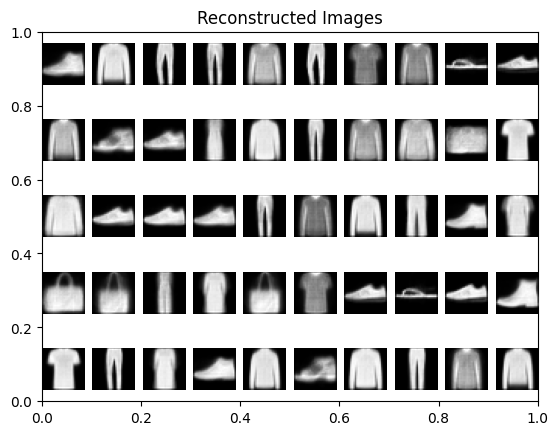

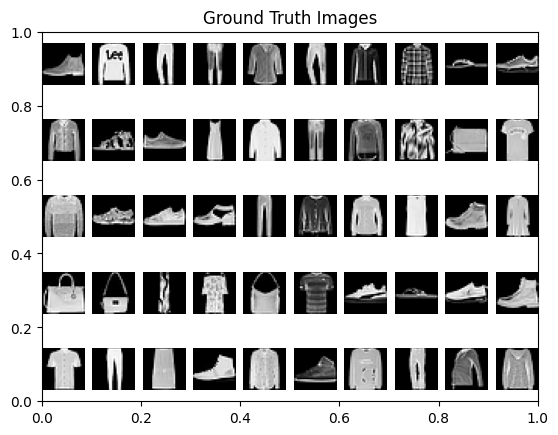

In [ ]:
plt.figure(1)
plt.title('Reconstructed Images')
for i in range(50):
    plt.subplot(5, 10, i+1)
    plt.imshow(xrec[i, ..., 0], cmap='gray')
    plt.axis('off')
plt.show()

plt.figure(2)
plt.title('Ground Truth Images')
for i in range(50):
    plt.subplot(5, 10, i+1)
    plt.imshow(test_x[i, ..., 0], cmap='gray')
    plt.axis('off')
plt.show()

In [ ]:
decoder = tf.keras.Model(inputs = model_1.get_layer('z_vector').output, outputs = model_1.outputs[0], name='decoder')
decoder.trainable = False
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ keras_tensor_159CLONE           │ (None, 2)              │             0 │
│ (InputLayer)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_expand1 (Dense)           │ (None, 32)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_expand2 (Dense)           │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_reshape (Dense)           │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3d (Reshape)            │ (None, 8, 8, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_transpose1                 │ (None, 16, 16, 64)     │         1,088 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_transpose2                 │ (None, 16, 16, 64)     │        65,600 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_transpose3                 │ (None, 16, 16, 64)     │        65,600 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_decoder (Flatten)       │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_final (Dense)             │ (None, 784)            │    12,845,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sigmoid_activation (Activation) │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_reshape (Reshape)        │ (None, 28, 28, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,984,496 (49.53 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 12,984,496 (49.53 MB)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step


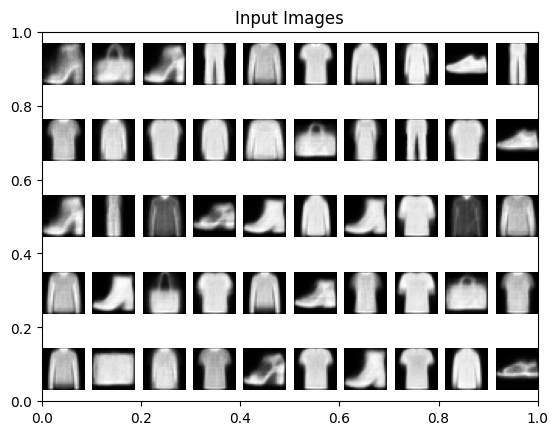

In [ ]:
noise_z = tf.constant(np.random.normal(size=[50,n_hidden]))
out_img = decoder.predict(noise_z)
plt.figure(3)
plt.title('Input Images')
for i in range(50):
    plt.subplot(5, 10, i+1)
    plt.imshow(out_img[i, ..., 0], cmap='gray')
    plt.axis('off')
plt.show()

In [ ]:
encoder = tf.keras.Model(inputs = model_1.inputs, outputs = model_1.get_layer('z_vector').output, name='encoder')
encoder.trainable = False
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv2D)      │ (None, 14, 14,    │      1,088 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn1                 │ (None, 14, 14,    │        256 │ conv1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky1 (LeakyReLU)  │ (None, 14, 14,    │          0 │ bn1[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2 (Conv2D)      │ (None, 7, 7, 64)  │     65,600 │ leaky1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn2                 │ (None, 7, 7, 64)  │        256 │ conv2[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky2 (LeakyReLU)  │ (None, 7, 7, 64)  │          0 │ bn2[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3 (Conv2D)      │ (None, 4, 4, 64)  │     65,600 │ leaky2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn3                 │ (None, 4, 4, 64)  │        256 │ conv3[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky3 (LeakyReLU)  │ (None, 4, 4, 64)  │          0 │ bn3[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_encoder     │ (None, 1024)      │          0 │ leaky3[0][0]      │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean_layer (Dense)  │ (None, 2)         │      2,050 │ flatten_encoder[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ log_var_layer       │ (None, 2)         │      2,050 │ flatten_encoder[… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_vector (Lambda)   │ (None, 2)         │          0 │ mean_layer[0][0], │
│                     │                   │            │ log_var_layer[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 137,156 (535.77 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 137,156 (535.77 KB)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


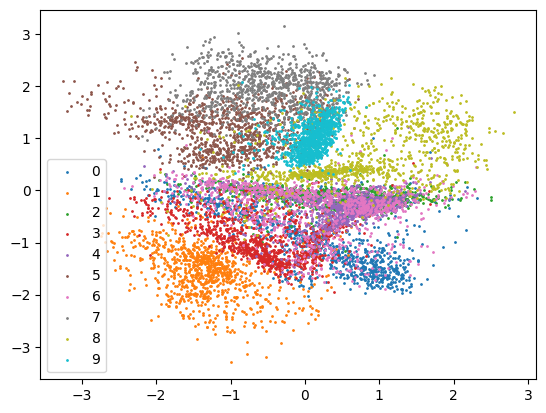

In [ ]:
z = encoder.predict(test_x)

plt.figure()

for i in range(10):
    idx = np.argwhere(test_y == i)[:,0]
    plt.scatter(z[idx,0],z[idx,1],s=1, label=str(i))
plt.legend(loc='best')
plt.show()

#### Visualización del espacio latente con T-SNE

Para entender cómo el VAE ha organizado la información en el espacio latente, aplicamos **T-SNE** (t-distributed Stochastic Neighbor Embedding), una técnica de reducción de dimensionalidad no lineal que permite proyectar representaciones de alta dimensión a dos dimensiones para su visualización.

Cada punto representa una imagen del conjunto de prueba, proyectada a partir de su representación latente. Los colores indican la etiqueta verdadera del dígito, lo que nos permite observar si el VAE ha aprendido una estructura significativa en el espacio latente.

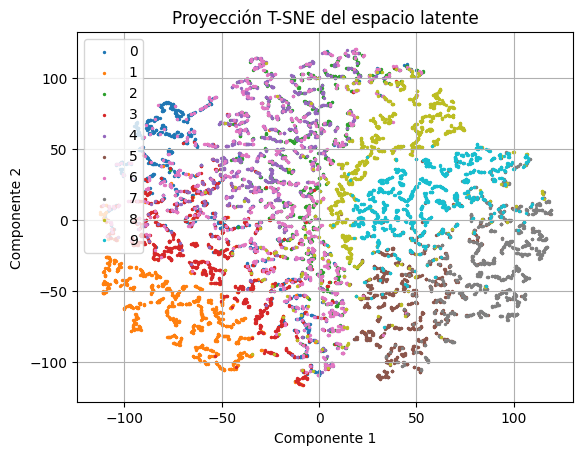

In [ ]:
perplexity = 10
tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
latent_tsne = tsne.fit_transform(z)

plt.figure()

for digit in range(10):

    idx = np.argwhere(test_y == digit)[:,0]
    plt.scatter(latent_tsne[idx, 0], latent_tsne[idx, 1], s=2, label=str(digit))

plt.title("Proyección T-SNE del espacio latente")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.legend(loc='best')
plt.grid(True)
plt.show()

#### 4.2. CVAE

In [ ]:
test_labels_one_hot = tf.one_hot(test_y, depth=10)  # Convertir etiquetas a one-hot
xrec, _, _ = model_2.predict([test_x, test_labels_one_hot])
#xrec, _, _ = model_2.predict(test_x)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step


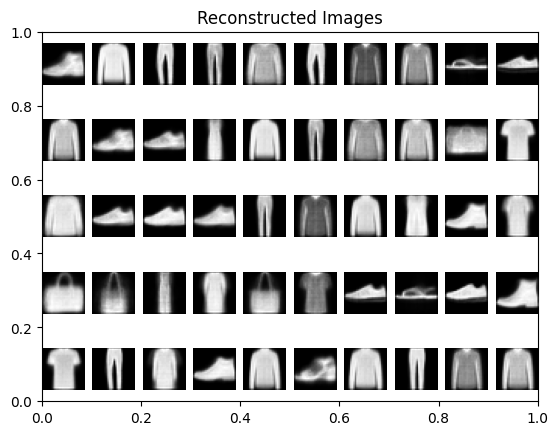

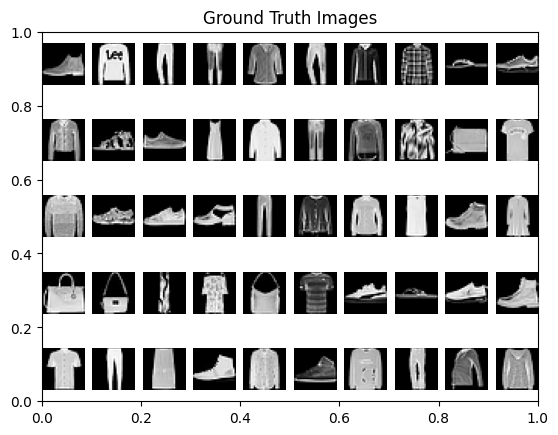

In [ ]:
plt.figure(1)
plt.title('Reconstructed Images')
for i in range(50):
    plt.subplot(5, 10, i+1)
    plt.imshow(xrec[i, ..., 0], cmap='gray')
    plt.axis('off')
plt.show()

plt.figure(2)
plt.title('Ground Truth Images')
for i in range(50):
    plt.subplot(5, 10, i+1)
    plt.imshow(test_x[i, ..., 0], cmap='gray')
    plt.axis('off')
plt.show()

In [ ]:
decoder = tf.keras.Model(inputs = model_2.get_layer('z_vector').output, outputs = model_2.outputs[0], name='decoder')
decoder.trainable = False
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ keras_tensor_191CLONE           │ (None, 2)              │             0 │
│ (InputLayer)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 32)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_26 (LeakyReLU)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_27 (LeakyReLU)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_14 (Reshape)            │ (None, 8, 8, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_21             │ (None, 16, 16, 64)     │         1,088 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_22             │ (None, 16, 16, 64)     │        65,600 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_23             │ (None, 16, 16, 64)     │        65,600 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 784)            │    12,845,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Reshape)          │ (None, 28, 28, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,980,336 (49.52 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 12,980,336 (49.52 MB)

In [ ]:
noise_z = tf.constant(np.random.normal(size=[50,n_hidden]))
out_img = decoder.predict(noise_z)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 344ms/step


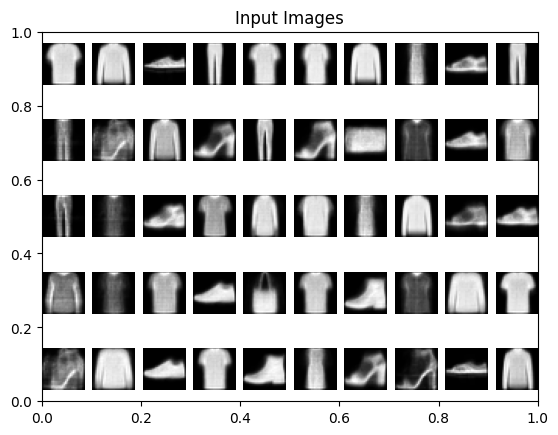

In [ ]:
plt.figure(3)
plt.title('Input Images')
for i in range(50):
    plt.subplot(5, 10, i+1)
    plt.imshow(out_img[i, ..., 0], cmap='gray')
    plt.axis('off')
plt.show()


In [ ]:
encoder = tf.keras.Model(inputs = model_2.inputs, outputs = model_2.get_layer('z_vector').output, name='encoder')
encoder.trainable = False
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_labels        │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_29 (Dense)    │ (None, 7840)      │     86,240 │ input_labels[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer         │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_13          │ (None, 28, 28,    │          0 │ dense_29[0][0]    │
│ (Reshape)           │ 10)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 28, 28,    │          0 │ input_layer[0][0… │
│ (Concatenate)       │ 11)               │            │ reshape_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 13, 13,    │     11,328 │ concatenate_3[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 13, 13,    │        256 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_23      │ (None, 13, 13,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 5, 5, 64)  │     65,600 │ leaky_re_lu_23[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 5, 5, 64)  │        256 │ conv2d_10[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_24      │ (None, 5, 5, 64)  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 1, 1, 64)  │     65,600 │ leaky_re_lu_24[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1, 1, 64)  │        256 │ conv2d_11[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_25      │ (None, 1, 1, 64)  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_10          │ (None, 64)        │          0 │ leaky_re_lu_25[0… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_30 (Dense)    │ (None, 2)         │        130 │ flatten_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ epsilon_layer       │ (None, 2)         │          0 │ dense_30[0][0]    │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_31 (Dense)    │ (None, 2)         │        130 │ flatten_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 229,796 (897.64 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 229,796 (897.64 KB)

In [ ]:
test_labels_one_hot = tf.one_hot(test_y, depth=10)  # Convertir etiquetas a one-hot
z = encoder.predict([test_x, test_labels_one_hot])

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


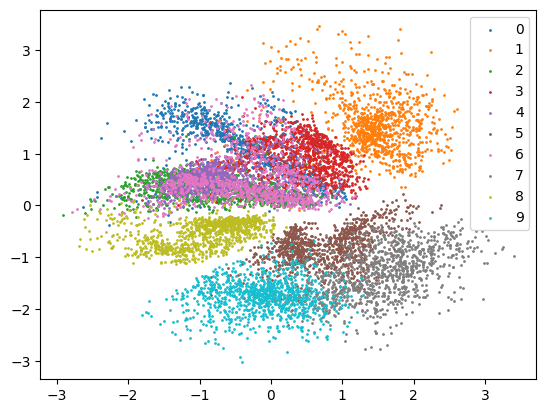

In [ ]:
plt.figure()

for i in range(10):
    idx = np.argwhere(test_y == i)[:,0]
    plt.scatter(z[idx,0],z[idx,1],s=1, label=str(i))
plt.legend(loc='best')
plt.show()

#### Visualización del espacio latente con T-SNE

Para entender cómo el VAE ha organizado la información en el espacio latente, aplicamos **T-SNE** (t-distributed Stochastic Neighbor Embedding), una técnica de reducción de dimensionalidad no lineal que permite proyectar representaciones de alta dimensión a dos dimensiones para su visualización.

Cada punto representa una imagen del conjunto de prueba, proyectada a partir de su representación latente. Los colores indican la etiqueta verdadera del dígito, lo que nos permite observar si el VAE ha aprendido una estructura significativa en el espacio latente.

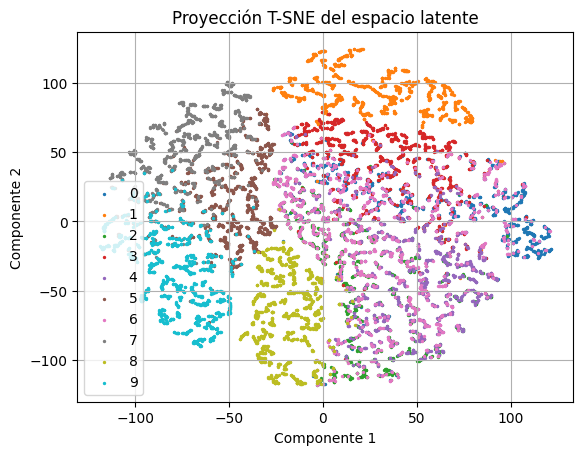

In [ ]:
perplexity = 10
tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
latent_tsne = tsne.fit_transform(z)

plt.figure()

for digit in range(10):

    idx = np.argwhere(test_y == digit)[:,0]
    plt.scatter(latent_tsne[idx, 0], latent_tsne[idx, 1], s=2, label=str(digit))

plt.title("Proyección T-SNE del espacio latente")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.legend(loc='best')
plt.grid(True)
plt.show()

#### 4.3. ConvVAE

In [ ]:
xrec, _, _ = model_3.predict(test_x)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


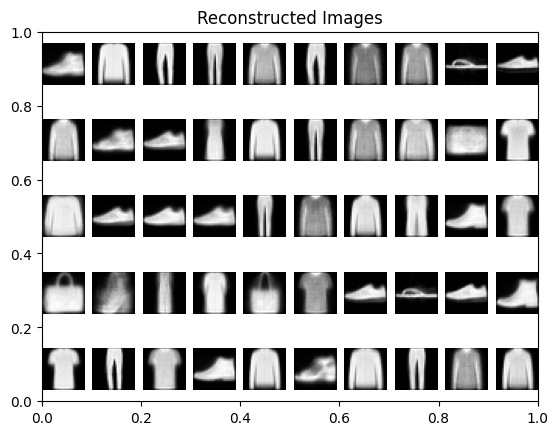

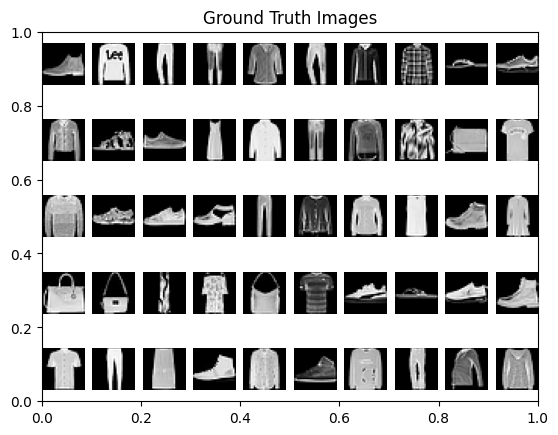

In [ ]:
plt.figure(1)
plt.title('Reconstructed Images')
for i in range(50):
    plt.subplot(5, 10, i+1)
    plt.imshow(xrec[i, ..., 0], cmap='gray')
    plt.axis('off')
plt.show()

plt.figure(2)
plt.title('Ground Truth Images')
for i in range(50):
    plt.subplot(5, 10, i+1)
    plt.imshow(test_x[i, ..., 0], cmap='gray')
    plt.axis('off')
plt.show()

In [ ]:
decoder = tf.keras.Model(inputs = model_3.get_layer('z_vector').output, outputs = model_3.outputs[0], name='decoder')
decoder.trainable = False
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ keras_tensor_221CLONE           │ (None, 2)              │             0 │
│ (InputLayer)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 32)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_31 (LeakyReLU)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_32 (LeakyReLU)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_15 (Reshape)            │ (None, 8, 8, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_24             │ (None, 16, 16, 64)     │         1,088 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_25             │ (None, 16, 16, 64)     │        65,600 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_26             │ (None, 16, 16, 64)     │        65,600 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 784)            │    12,845,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Reshape)          │ (None, 28, 28, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,980,336 (49.52 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 12,980,336 (49.52 MB)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 361ms/step


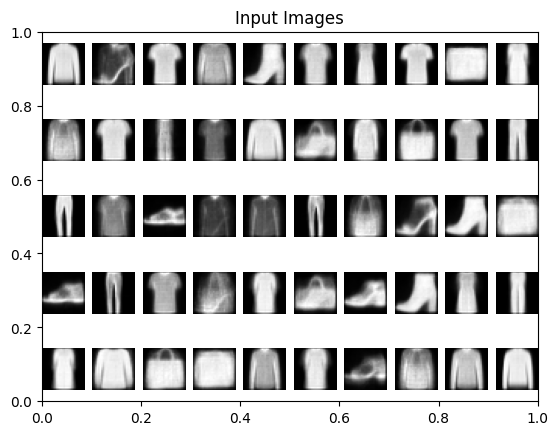

In [ ]:
noise_z = tf.constant(np.random.normal(size=[50,n_hidden]))
out_img = decoder.predict(noise_z)
plt.figure(3)
plt.title('Input Images')
for i in range(50):
    plt.subplot(5, 10, i+1)
    plt.imshow(out_img[i, ..., 0], cmap='gray')
    plt.axis('off')
plt.show()

In [ ]:
encoder = tf.keras.Model(inputs = model_3.inputs, outputs = model_3.get_layer('z_vector').output, name='encoder')
encoder.trainable = False
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 13, 13,    │      1,088 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 13, 13,    │        256 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_28      │ (None, 13, 13,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 5, 5, 64)  │     65,600 │ leaky_re_lu_28[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 5, 5, 64)  │        256 │ conv2d_13[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_29      │ (None, 5, 5, 64)  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 1, 1, 64)  │     65,600 │ leaky_re_lu_29[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1, 1, 64)  │        256 │ conv2d_14[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_30      │ (None, 1, 1, 64)  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_12          │ (None, 64)        │          0 │ leaky_re_lu_30[0… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_35 (Dense)    │ (None, 2)         │        130 │ flatten_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ epsilon_layer       │ (None, 2)         │          0 │ dense_35[0][0]    │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_36 (Dense)    │ (None, 2)         │        130 │ flatten_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_vector (Lambda)   │ (None, 2)         │          0 │ dense_35[0][0],   │
│                     │                   │            │ epsilon_layer[0]… │
│                     │                   │            │ dense_36[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 133,316 (520.77 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 133,316 (520.77 KB)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


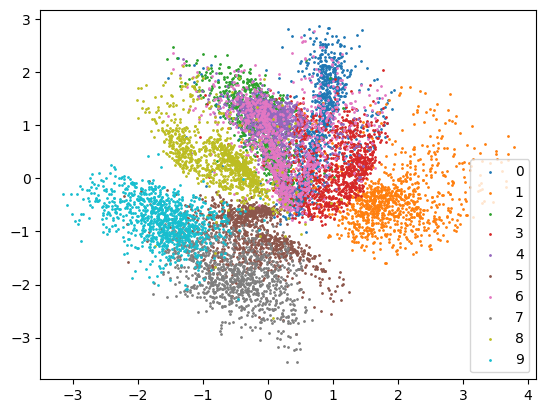

In [ ]:
z = encoder.predict(test_x)

plt.figure()

for i in range(10):
    idx = np.argwhere(test_y == i)[:,0]
    plt.scatter(z[idx,0],z[idx,1],s=1, label=str(i))
plt.legend(loc='best')
plt.show()

#### Visualización del espacio latente con T-SNE

Para entender cómo el VAE ha organizado la información en el espacio latente, aplicamos **T-SNE** (t-distributed Stochastic Neighbor Embedding), una técnica de reducción de dimensionalidad no lineal que permite proyectar representaciones de alta dimensión a dos dimensiones para su visualización.

Cada punto representa una imagen del conjunto de prueba, proyectada a partir de su representación latente. Los colores indican la etiqueta verdadera del dígito, lo que nos permite observar si el VAE ha aprendido una estructura significativa en el espacio latente.

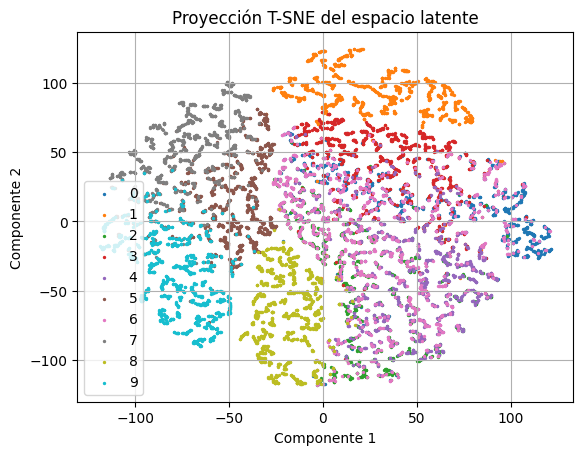

In [ ]:
perplexity = 10
tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
latent_tsne = tsne.fit_transform(z)

plt.figure()

for digit in range(10):

    idx = np.argwhere(test_y == digit)[:,0]
    plt.scatter(latent_tsne[idx, 0], latent_tsne[idx, 1], s=2, label=str(digit))

plt.title("Proyección T-SNE del espacio latente")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.legend(loc='best')
plt.grid(True)
plt.show()

### Conclusión

A lo largo de esta práctica, se pudo entender mucho mejor el tipo de arquitectura generativa profunda del modelo VAE, incluyendo su codificador, espacio latente, decodificador y casos de uso. Se destaca que no hay una arquitectura única y que detalles como el número de capas, la convoluciones, convoluciones transpuestas, hiperámetros como los vectores de ruido, la beta de divergencia, dependen mucho del dataset en cuestion, el problema a resolver y los recursos disponibles. En esta práctica, el valor de beta=1.0 para el CVAE fue el que mejor funcionó y el que tuvo menor tiempo de ejecución, generando imágenes decentes y una visualización bien separada en el t-SNE, el cual también fue de mucha ayuda para visualizar mejor el espacio latente y sus componentes. Si bien ese fue el modelo que mejor funcionó, los otros tuvieron resultados bastante semejante y valores de pérdida cercanos. Los modelos tuvieron parámetros similares pero por diseño de arquitectura; posiblemente otras arquitecturas y un apartado de optimización de hiperparámetros mejoraría el desempeño del modelo. Pero los resultados presentes son bastante buenos, particularmente el del CVAE que tuvo generaciones dirigidas gracias al vector de codificación one-hot.